In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
#from torchvision import transforms
#from torchvision.utils import make_grid

In [2]:
df_train = pd.read_csv('data/train.csv')
df_train.head()


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df_test = pd.read_csv('data/test.csv')
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
from sklearn.preprocessing import StandardScaler
y = np.array(df_train['label'])
X = np.array(df_train.iloc[:,1:])
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
X = X / 255
print(X.shape, y.shape)
print(type(y), type(X))
#print(X[:5])
#print(y[:5])

(42000, 784) (42000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long

X_val = torch.from_numpy(X_val).type(torch.FloatTensor)
y_val = torch.from_numpy(y_val).type(torch.LongTensor)

In [6]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
#
#
        # no entity name for each layer
        # conv-batchnorm-relu * 4, maxpool * 2
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
          
        # dropout-fc-batchnorm-relu *2 + dropout-fc
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10),
        )
          
        # weight init(conv, batchnorm, fc)
        for m in self.features.children():
            # conv layer weight initialization
            # n 为该层参数数量
            # torch.Tensor.normal_(mean=0, std=1, *, generator=None)
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            # batchnorm weight init
            # torch.Tensor.fill_(value)
            # Fills self tensor with the specified value.
            elif isinstance(m, nn.BatchNorm2d):
#                 print(m.weight.data.shape,m.bias.data.shape)
#                 y=γ(x-μ)/σ+β，weight=γ，bias=β
#                 torch.Size([32]) torch.Size([32])
#                 torch.Size([32]) torch.Size([32])
#                 torch.Size([64]) torch.Size([64])
#                 torch.Size([64]) torch.Size([64])
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        for m in self.classifier.children():
            # fc weight init
            # weight Xaview initialization
            # W = np.random.randn(fan_in, fan_out) / np.sqrt(fan_in)
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x
#         self.cnn1 = nn.Conv2d(1, 16, 5)
#         self.relu1=nn.ReLU()
#         self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
#         self.cnn2=nn.Conv2d(16, 32, 5)
#         self.relu2 = nn.ReLU()
#         self.maxpool2 = nn.MaxPool2d(kernel_size=2)
#         self.conv2_drop = nn.Dropout2d()
        
#         self.dropout = nn.Dropout()

#         self.fc1 = nn.Linear(32*4*4, 10)
        
#     def forward(self, x):
        
#         out = self.cnn1(x)
#         out = self.relu1(out)
#         out = self.maxpool1(out)
        
#         out =self.cnn2(out)
#         out = self.relu2(out)
#         out = self.maxpool2(out)
#         out = self.conv2_drop(out)
        
#         out = out.view(out.size(0), -1)
#         out = self.dropout(out)
#         out = self.fc1(out)
#         """
#         torch.Size([200, 1, 28, 28])
#         torch.Size([200, 16, 24, 24])
#         torch.Size([200, 16, 24, 24])
#         torch.Size([200, 16, 12, 12])
#         torch.Size([200, 32, 8, 8])
#         torch.Size([200, 32, 8, 8])
#         torch.Size([200, 32, 4, 4])
#         torch.Size([200, 32, 4, 4])
#         torch.Size([200, 512])
#         torch.Size([200, 512])
#         torch.Size([200, 10])
#         """
#         return out
    
batch_size = 300
n_iters = 4000
num_epochs = n_iters * batch_size / len(y_train) 
num_epochs = int(num_epochs)
print('Number of epochs is {}.'.format(num_epochs))
# TensorDataset wrapping data and target tensors.
# Each sample will be retrieved by indexing 
# both tensors along the first dimension.
train = TensorDataset(X_train, y_train)
val = TensorDataset(X_val, y_val)
#print(type(train))

# Data loader. Combines a dataset and a sampler, 
# and provides single- or multi-process iterators over the dataset.
train_loader = DataLoader(train, batch_size = batch_size)
val_loader = DataLoader(val, batch_size = batch_size)
#print(type(train_loader))

model = CNNModel()
# The input is expected to contain scores for each class, 
# a 2D Tensor of size (minibatch, C).
# A class index (0 to C-1) as the target for each value 
# of a 1D tensor of size minibatch
# The loss can be described as:
# loss(x, class) = -log(exp(x[class]) / (\sum_j exp(x[j])))
#               = -x[class] + log(\sum_j exp(x[j]))
criterion  = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
learning_rate = 0.001
momentum = 0
optimizer = optim.Adam(model.parameters(), lr=learning_rate)#, momentum=momentum)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
count_minibatches = 0
loss_list = []
iteration_list = []
accuracy_list = []

Number of epochs is 35.


In [7]:

for epoch in range(num_epochs):
    #print('epoch: {}'.format(epoch))
    for i, (X_train_, y_train_) in enumerate(train_loader):
        X_train_ = Variable(X_train_.view([batch_size, 1, 28, 28]))
        y_train_ = Variable(y_train_)
        if torch.cuda.is_available():
            X_train_ = X_train_.cuda()
            y_train_ = y_train_.cuda()
        
        optimizer.zero_grad()
        model.train();
        scores = model(X_train_)
        print(scores)
        print(y_train_)
        # print(type(scores))
        # <class 'torch.Tensor'>
        loss = criterion (scores, y_train_)
        # print(type(loss))
        # <class 'torch.Tensor'>
        loss.backward()
        
        optimizer.step()
        del X_train_, y_train_
        count_minibatches += 1
        if count_minibatches % 25 == 0:
            correct = 0
            total =0
            for (X_val_, y_val_) in val_loader:
                X_val_ = Variable(X_val_.view([batch_size,1,28,28]))
                y_val_ = Variable(y_val_)
                if torch.cuda.is_available():
                    X_val_ = X_val_.cuda()
                    y_val_ = y_val_.cuda()
                model.eval()
                scores = model(X_val_)
                pred_y = torch.max(scores.data, 1)[1]
                total += len(y_val_)
                correct += (pred_y == y_val_).sum()
                del X_val_, y_val_
            accuracy = 100 * correct / float(total)
            
            loss_list.append(loss.data)
            iteration_list.append(count_minibatches)
            accuracy_list.append(accuracy)
            if count_minibatches % 200 == 0:
                print('Iteration: {}   Loss: {:.4f}   Accuracy:{} %' \
                      .format(count_minibatches, loss, accuracy))

CNNModel(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Drop

tensor([[ 5.0978e-02, -1.0678e+00, -2.4929e+00,  ...,  2.6116e+00,
         -1.8012e+00, -1.7815e+00],
        [ 1.1816e+00,  2.5119e-01,  1.1735e+00,  ..., -2.4972e+00,
         -1.6358e-01, -7.7276e-01],
        [ 2.4393e+00,  2.3784e+00, -1.0686e+00,  ...,  8.9269e-01,
          5.8166e-02, -2.4844e+00],
        ...,
        [-1.3677e-01,  1.0352e-02,  2.9376e-01,  ...,  1.5471e+00,
          8.6401e-01, -3.7954e-01],
        [ 8.9133e-01, -2.4517e+00, -1.9919e+00,  ..., -1.9284e+00,
         -1.2139e+00,  1.1918e+00],
        [-5.7044e-01,  1.9397e-01,  4.9822e-01,  ...,  9.8051e-01,
         -9.4239e-01,  4.0428e-01]])


CNNModel(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Drop

tensor([[-0.0623,  0.0819, -0.0074,  ...,  1.3246, -2.1681, -1.8883],
        [ 1.0150, -1.0917, -1.4656,  ...,  0.7483,  0.6908, -0.3388],
        [-1.4790, -1.8513,  0.3895,  ...,  1.2412, -0.0965, -1.8654],
        ...,
        [ 0.1989,  0.4399, -0.0915,  ...,  0.9369, -1.0624, -1.3901],
        [-0.6183, -0.2136, -1.1454,  ..., -1.1327, -0.9363, -1.0195],
        [-0.3283,  1.9133, -0.7274,  ..., -1.6976, -0.8090,  0.6766]])


CNNModel(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Drop

tensor([[-1.5679, -1.6539, -2.2365,  ...,  0.7900, -1.8483,  0.5811],
        [-0.1568,  1.4377,  0.3188,  ..., -0.1041,  0.6387, -1.1047],
        [-1.6421,  2.4609, -0.7335,  ...,  1.5565, -0.1450,  2.3339],
        ...,
        [ 1.3417,  0.4751, -1.1750,  ..., -0.6634,  0.8107, -0.2247],
        [-0.1649,  0.7742,  0.6330,  ..., -1.7280, -1.9415, -0.7759],
        [-1.4917,  1.3924, -2.9208,  ...,  0.5546, -0.4520, -1.9659]])


CNNModel(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Drop

tensor([[-1.8540, -2.1258, -1.5251,  ..., -0.9817, -0.0483,  2.2768],
        [ 1.0171,  1.4291, -1.4705,  ...,  1.1626, -0.4545,  3.3267],
        [-1.0149,  0.4457,  0.5452,  ..., -0.3576,  0.5633,  0.6062],
        ...,
        [-2.1056, -3.8936,  1.4392,  ..., -0.6089,  1.8401, -1.5222],
        [ 0.3024,  3.4235, -1.2397,  ..., -0.6623, -1.4960,  1.7121],
        [ 0.2816, -1.5693, -0.5280,  ..., -1.4121,  0.8830, -2.1438]])


CNNModel(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Drop

tensor([[-2.4564, -1.9725,  3.5965,  ...,  0.6127, -0.0701, -3.5783],
        [-0.4815, -0.6267,  1.2299,  ..., -0.8538,  0.3641,  0.6293],
        [-0.2209, -0.3118,  0.4412,  ...,  0.7351,  0.6312,  2.9861],
        ...,
        [-0.1760,  0.8013, -0.3191,  ...,  0.0613,  0.0516,  0.2571],
        [ 0.1341, -0.8690,  0.1790,  ..., -1.7383, -2.2237,  1.7526],
        [ 0.5287, -0.4598, -0.3701,  ...,  2.0347,  0.6318,  0.6739]])


CNNModel(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Drop

tensor([[ 0.4851, -3.6094, -2.2108,  ...,  0.1490,  0.6729,  0.5874],
        [-0.8305,  0.8936,  0.7881,  ..., -0.4837,  3.5626,  0.2581],
        [ 3.3760, -0.7354,  0.0592,  ..., -1.6734,  0.5778, -3.3000],
        ...,
        [ 0.8434, -2.9785,  0.9605,  ..., -1.5211,  0.9614,  1.2497],
        [ 0.6594, -1.4656, -1.4965,  ...,  1.3479, -2.8591, -0.3589],
        [-1.9027,  0.8129, -1.1385,  ..., -0.3553,  0.5780,  0.0584]])


CNNModel(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Drop

tensor([[-1.6886e+00, -1.1534e-02, -1.3856e+00,  ..., -8.0319e-01,
          1.3983e+00, -9.6156e-02],
        [-2.8185e+00, -2.7486e-01, -1.2896e-02,  ...,  1.8016e+00,
         -1.3744e+00,  2.6464e+00],
        [-1.2680e+00,  2.2654e+00, -7.4614e-02,  ..., -1.1698e+00,
          2.5896e-02, -3.2084e-01],
        ...,
        [-9.0887e-01, -3.0007e-01, -1.4042e+00,  ...,  3.5182e+00,
         -9.2274e-01, -1.0177e+00],
        [-8.8819e-01,  9.5134e-01,  5.7063e-01,  ..., -3.7251e-01,
         -2.2512e+00, -2.4526e+00],
        [-1.0692e+00, -1.8204e+00, -1.8593e+00,  ...,  4.1828e-01,
         -5.9289e-01,  1.4655e+00]])


CNNModel(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Drop

tensor([[-2.4820e+00, -6.0090e-01, -1.4001e+00,  ..., -4.7497e-01,
          1.1002e+00,  2.5198e+00],
        [-2.1282e+00,  1.5167e+00, -7.9740e-01,  ..., -2.0286e+00,
         -1.2194e-01,  1.9014e-01],
        [-4.1028e-01,  8.3271e-01, -1.1331e+00,  ...,  1.2713e+00,
         -1.2252e+00,  6.4694e-01],
        ...,
        [ 1.9969e+00, -2.7992e+00,  8.6231e-01,  ...,  7.2224e-02,
         -2.3095e+00,  1.1355e+00],
        [-3.6942e+00, -1.4396e+00,  9.0206e-01,  ..., -4.7862e-01,
         -1.9557e+00, -1.7493e+00],
        [-1.2511e+00, -2.1934e+00,  7.7732e-01,  ...,  6.0958e-01,
         -5.7348e-01,  3.5160e+00]])


KeyboardInterrupt: 

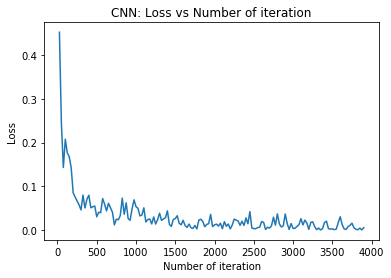

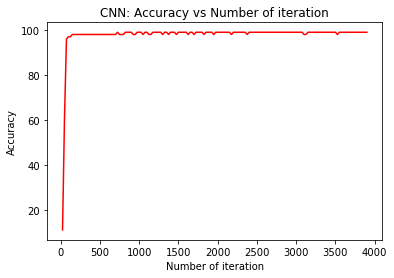

In [28]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [29]:
X_test = df_test.values
X_test = (torch.from_numpy(X_test) \
                .type(torch.FloatTensor) \
                / 255) \
                .view([-1,1,28,28])
print(type(X_test), X_test.shape)

model.eval()
test_pred = torch.LongTensor()
if torch.cuda.is_available():
    test_pred = test_pred.cuda()
test_loader = DataLoader(X_test, batch_size=batch_size)
for i, batch in enumerate(test_loader):
    batch = Variable(batch)
    if torch.cuda.is_available():
        batch = batch.cuda()
    scores_test = model(batch)
    del batch
    pred_y_test = torch.max(scores_test.data, 1)[1]
    test_pred = torch.cat((test_pred, pred_y_test), dim=0)

print(type(test_pred), test_pred.shape)

<class 'torch.Tensor'> torch.Size([28000, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([28000])


In [30]:
result = pd.Series(test_pred, name='Label')
result.index += 1
result.to_csv('result_cnn.csv', index_label='ImageId', header=True)